In [ ]:
import geopandas as gpd 
import xarray as xr 
import rioxarray as rxr
import matplotlib.pyplot as plt 
from pathlib import Path
import numpy as np
from scipy.interpolate import griddata

# matplotlub basemap
from mpl_toolkits.basemap import Basemap

from utils.read_files import read_from_control, make_default_path

Compare the grid cells by overlaying the grid for:
- ERA5 geopotential height
- PRISM 800-m
- gridment 4-km
- CERES 
- Stage IV

In [ ]:
# import the shapefiles for the East River and the Tuolumne River
# Store the name of the 'active' file in a variable
controlFile = 'control_EastRiver.txt'
# basin name and outlet gauge id
storage_path = Path(read_from_control(controlFile, "root_path"))
east_river_shp = storage_path / "domain_EastRiver/shapefiles/catchment/EastRiver.shp"
tuolumne_river_shp = storage_path / "domain_TuolumneRiver/shapefiles/catchment/TuolumneRiver.shp"

east_river = gpd.read_file(east_river_shp)
tuolumne_river = gpd.read_file(tuolumne_river_shp)

In [152]:
# Open example for each of the datasets 
era5_ds = xr.open_dataset(storage_path / "ERA5_surface_geopotential.nc")
era5_ds = era5_ds['z'].rio.write_crs(4326) # add the crs to the dataset

# Open PRISM 
prism_800m_ds = rxr.open_rasterio(storage_path / 'prism' / 'PRISM_800m_annual_normals' / 'PRISM_ppt_30yr_normal_800mM4_annual_bil.bil')

# Open the CERES dataset
ceres_ds = xr.open_dataset(storage_path / "CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Subset_20000301-20240731.nc")
# subtract 360 from the lon variable
ceres_ds['lon'] = ceres_ds['lon'] - 360
# add the crs to the dataset
ceres_ds = ceres_ds.rio.write_crs(4326)

east_river_gridmet_ds = xr.open_dataset(storage_path / "domain_EastRiver" / "forcing" / "1_raw_data" / "gridmet_pr.nc")
tuolumne_river_gridmet_ds = xr.open_dataset(storage_path / "domain_TuolumneRiver" / "forcing" / "1_raw_data" / "gridmet_pr.nc")
east_river_stageiv_ds = xr.open_dataset(storage_path / "domain_EastRiver" / "forcing" / "1_raw_data" / "stageIV" / "stageiv_2022_EastRiver.nc")
# tuolumne_river_stageiv_ds = xr.open_dataset(storage_path / "TuolumneRiver/stageIV/stageiv_2022_TuolumneRiver.nc")

In [34]:
# clip the era5 dataset to the east river basin
east_river_era5_ds = era5_ds.rio.clip_box(east_river.total_bounds[0], east_river.total_bounds[1], east_river.total_bounds[2], east_river.total_bounds[3])
# clip the era5 dataset to the tuolumne river basin
tuolumne_river_era5_ds = era5_ds.rio.clip_box(tuolumne_river.total_bounds[0], tuolumne_river.total_bounds[1], tuolumne_river.total_bounds[2], tuolumne_river.total_bounds[3])

# clip the prism dataset to the east river basin
east_river_prism_ds = prism_800m_ds.rio.clip_box(east_river.total_bounds[0], east_river.total_bounds[1], east_river.total_bounds[2], east_river.total_bounds[3])
# clip the prism dataset to the tuolumne river basin
tuolumne_river_prism_ds = prism_800m_ds.rio.clip_box(tuolumne_river.total_bounds[0], tuolumne_river.total_bounds[1], tuolumne_river.total_bounds[2], tuolumne_river.total_bounds[3])

# clip the ceres dataset to the east river basin
# east_river_ceres_ds = ceres_ds.rio.clip_box(east_river.total_bounds[0], east_river.total_bounds[1], east_river.total_bounds[2], east_river.total_bounds[3])
# clip the ceres dataset to the tuolumne river basin
# tuolumne_river_ceres_ds = ceres_ds.rio.clip_box(tuolumne_river.total_bounds[0], tuolumne_river.total_bounds[1], tuolumne_river.total_bounds[2], tuolumne_river.total_bounds[3])

Text(0.5, 1.0, 'Grid Comparison over East River Basin')

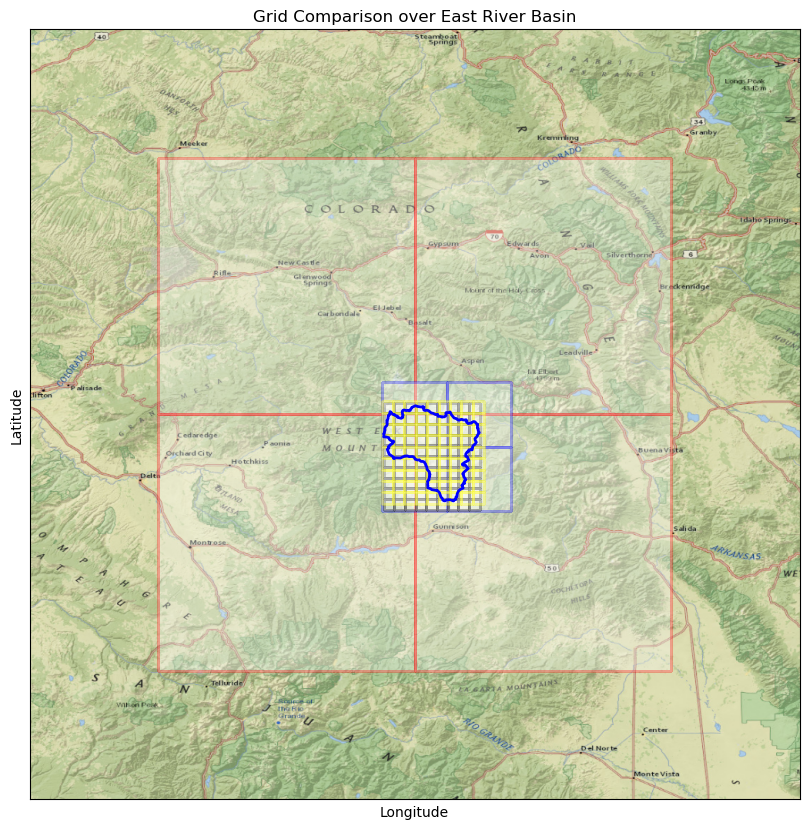

In [148]:
# Load datasets (assuming they're already opened)
# ceres_ds, east_river_era5_ds, east_river_prism_ds, east_river_gridmet_ds, east_river

fig, ax = plt.subplots(figsize=(10, 10))

# Set up Basemap (adjust lat/lon boundaries as needed)
m = Basemap(projection='cyl', 
            llcrnrlat=ceres_ds['lat'].min()-1, urcrnrlat=ceres_ds['lat'].max()+1,
            llcrnrlon=ceres_ds['lon'].min()-1, urcrnrlon=ceres_ds['lon'].max()+1,
            resolution='i', ax=ax)

# Add shaded relief
maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]
m.arcgisimage(service=maps[2], xpixels=1000, verbose=False)

# Convert lat/lon to Basemap coordinates if needed
ny = ceres_ds['lat'].shape[0]; nx = ceres_ds['lon'].shape[0]
lons, lats = np.meshgrid(ceres_ds['lon'], ceres_ds['lat'])
x, y = m(lons, lats)

# Plot CERES grid in red
ax.pcolormesh(x, y, np.zeros_like(x), cmap='Greys', edgecolors='red', linewidth=1, alpha=0.3)

# Plot ERA5 grid in blue
ny = east_river_era5_ds['latitude'].shape[0]; nx = east_river_era5_ds['longitude'].shape[0]
lons, lats = np.meshgrid(east_river_era5_ds['longitude'], east_river_era5_ds['latitude'])
x, y = m(lons, lats)
ax.pcolormesh(x, y, np.zeros_like(x), cmap='Greys', edgecolors='blue', linewidth=1, alpha=0.3)

# Plot GridMet grid in black
ny = east_river_gridmet_ds['y'].shape[0]; nx = east_river_gridmet_ds['x'].shape[0]
lons, lats = np.meshgrid(east_river_gridmet_ds['x'], east_river_gridmet_ds['y'])
x, y = m(lons, lats)
ax.pcolormesh(x, y, np.zeros_like(x), cmap='Greys', edgecolors='black', linewidth=1, alpha=0.3)

# plot stageIV grid in yellow
ny = east_river_stageiv_ds['y'].shape[0]; nx = east_river_stageiv_ds['x'].shape[0]
lons, lats = np.meshgrid(east_river_stageiv_ds['x'], east_river_stageiv_ds['y'])
x, y = m(lons, lats)
ax.pcolormesh(x, y, np.zeros_like(x), cmap='Greys', edgecolors='yellow', linewidth=1, alpha=0.3)

# Plot PRISM grid in green
ny = east_river_prism_ds['y'].shape[0]; nx = east_river_prism_ds['x'].shape[0]
lons, lats = np.meshgrid(east_river_prism_ds['x'], east_river_prism_ds['y'])
x, y = m(lons, lats)
# ax.pcolormesh(x, y, np.zeros_like(x), cmap='Greys', edgecolors='green', linewidth=1, alpha=0.3)

# Plot East River basin boundary
# convert east_river to basemap coordinates
m.readshapefile("/storage/dlhogan/summa_modeling_data/EastRiver/EastRiver", 'east_river', linewidth=2, color='blue')
# east_river.plot(ax=ax, color='blue', alpha=0.5)

# Labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Grid Comparison over East River Basin")